<a href="https://colab.research.google.com/github/guiaustregesilo-ds/Loyalty-Program-with-Clustering/blob/main/c03_gca_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **High Value Customer Identification**

## PLANNING IoT

### Input

**1 - Business Problem**:
  - Selecting the most valuable customers to be included in a loyalty program.

**2 - Dataset**
  - Online e-commerce sales over a one-year period.

### Output

**1 -  Identifying the participants for the "Royalty" program."**
  - Lista: client_id | id_royalty
            1234     | yes/R
            4567     | no/R

**2 - Business Questions Report: Royalty Program**

    - 1. Who are the people eligible to participate in the program?"

    - 2.  How many customers will be in the group?

    - 3. What are the main characteristics of these customers?

    - 4. What is the revenue contribution of the selected customers?

    - 5. What is the expected revenue for this group in the coming months?

    - 6. & 7. What are the conditions for a person to be eligible (or not)?

    - 8. How can we prove the program is better than the rest of the base?

    - 9. What actions can the marketing team take to increase revenue?

### Tasks

- **Who are the people eligible to participate in the "Royalty" program?**

    - What does it mean to be eligible? What are "high-value" customers?

    - Revenue ?
        - High Average Order Value (AOV);
        - High Lifetime Value (LTV);
        - Low Recency;
        - High Basket Size;
        - Low Churn probability;
        - High predicted LTV;
        - High purchase propensity.

    - Cost ?
        - Low return rate;

    - Shopping experience ?
        - High average rating.

- **2. How many customers will be part of the group?**
    - Total number of customers;
    - Percentage of the filtered group.

- **3. What are the main characteristics of these customers?**
    - List customer characteristics:
        - Age;
        - Location;
    - Purchasing behavior characteristics:
        - Clustering attributes.

- **4. What is the revenue contribution percentage of the selected customers for "Royalty"**
    -  Total annual revenue;
    -  Total revenue of the "Loyalty" group.

- **5. What is the expected revenue for this group in the coming months?**
    -  LTV of the "Loyalty" group;
    -  Cohort analysis.

- **6. What are the conditions for a person to be eligible for "Royalty"**
    -  Define the frequency {1 month, 3 months};
    -  The person needs to be similar to those in the loyalty group.

- **7. What are the conditions for a person not to be eligible for "Royalty":**
    -  Define the frequency {1 month, 3 months};
    -  The person needs to be dissimilar from those in the loyalty group.

- **8. How can we prove the "Royalty" program is more effective than the rest of the customer base?**
    -  A/B Testing;
    -  Bayesian A/B Testing;
    -  Hypothesis Testing.

- **9. Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    -  Discount;
    -  Exclusive access to products;
    -  Free shipping or a shipping discount;
    -  Company visit.

## 1.0 Benchmark Solutions

### 1.1 Desk Research


# 0.0 IMPORTS

In [95]:
import pandas                            as pd
import numpy                             as np
import re

import umap.umap_                        as umap

import seaborn                           as sns

from google.colab         import drive
drive.mount('/content/drive')

from matplotlib           import pyplot  as plt
from plotly               import express as px

from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.cluster      import KMeans
from sklearn              import cluster as c
from sklearn              import metrics as m


from yellowbrick.cluster  import KElbowVisualizer, SilhouetteVisualizer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.1 HELPER FUNCTIONS

In [54]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [29, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

## 0.2 LOAD DATASET

In [55]:
# load data
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Programa de Fidelidade com Clusterização/data/Ecommerce.csv', encoding='ISO-8859-1')

# drop extra column
df_raw = df_raw.drop(columns='Unnamed: 8', axis=1)

# 1.0 DATA DESCRIPTION

In [56]:
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [57]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

In [58]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 DATA DIMENSION

In [59]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 DATA TYPES

In [60]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,object
unit_price,float64
customer_id,float64
country,object


## 1.4 CHECK NA'S

In [61]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,1454
quantity,0
invoice_date,0
unit_price,0
customer_id,135080
country,0


## 1.5 FILLOUT NA'S

In [62]:
# remove nas
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:2f}'.format(1 - (df1.shape[0] / df_raw.shape[0])))

Removed data: 0.249267


In [63]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,0
quantity,0
invoice_date,0
unit_price,0
customer_id,0
country,0


## 1.6 CHANGE TYPES

In [64]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,object
unit_price,float64
customer_id,float64
country,object


In [65]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 DESCRIPTIVE STATISTICS

In [66]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 NUMERICAL ATTRIBUTS

In [67]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.1.1 NUMERICAL ATTRIBUTES - INVESTIGATING


In [68]:
# Quantity Negative - Purchase returns ?

# Unit price 0 - Special offer ?

### 1.7.2 CATEGORICAL STATISTICS

In [69]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [99]:
# invoice_no
len(cat_attributes.loc[cat_attributes['invoice_no'].apply( lambda x: bool(re.search('[^0-9]+', x) )), 'invoice_no'].drop_duplicates())

#cat_attributes['invoice_no'].apply(lambda x:))

3654

In [106]:
# stock_code
#len(cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search('[^0-9]+', x) )), 'stock_code'].drop_duplicates())

#at_least_one_string = len(cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: not bool(re.search('[0-9]+', x) )), 'stock_code'])
#print('At least one string: {}'.format(at_least_one_string))

#
#cat_attributes.loc[cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search('[a-zA-Z]$', x) )), 'stock_code'].unique()]

df1.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search('^[a-zA-Z]+$', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583,France
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
386,536403,POST,POSTAGE,1,2016-11-29,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,12662,Germany
2239,536569,M,Manual,1,2016-11-29,1.25,16274,United Kingdom


# 2.0 FEATURE SELECTION

In [109]:
df2 = df1.copy()

In [113]:
# NUMERICAL ATTRIBUTES
# unit_price
df2 = df2.loc[df2['unit_price'] > 0.030, :]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]

# quantity - negative number means 'product return'
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

In [112]:
df2.loc[df2['quantity'] < 0, :].sort_values('invoice_no').head(20)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2016-11-29,4.25,17897,United Kingdom


# 3.0 FEATURE ENGINEERING

In [114]:
df3 = df2.copy()

## 3.1 FEATURE CREATION

In [115]:
df3.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [116]:
# data reference
df3_ref = df3.drop(['invoice_no', 'stock_code', 'description', 'quantity',
                    'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

# gross revenue
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# monetary
df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df3_ref = pd.merge(df3_ref, df_monetary, on='customer_id', how='left')

# recency - last day purchase
df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df3_ref = pd.merge(df3_ref, df_recency, on='customer_id', how='left')

# frequency
df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df3_ref = pd.merge(df3_ref, df_freq, on='customer_id', how='left')

# AVG Ticket
df3_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df3_ref = pd.merge(df3_ref, df3_avg_ticket, on='customer_id', how='left')


In [117]:
df3_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3089.10,46,16,15.923196
2,12583,6629.34,2,17,28.209957
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# 4.0 EXPLORATORY DATA ANALYSIS

In [124]:
df4 = df3_ref.copy()

# 5.0 DATA PREPARATION

In [125]:
df5 = df4.copy()

# 6.0 FEATURE SELECTION

In [126]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE-TUNNING

In [127]:
X = df6.drop(columns='customer_id')

In [129]:
cluster = [2, 3, 4, 5, 6, 7]

## 7.1 WITHIN-CLUSTER SUM OF SQUARE ( WSS )

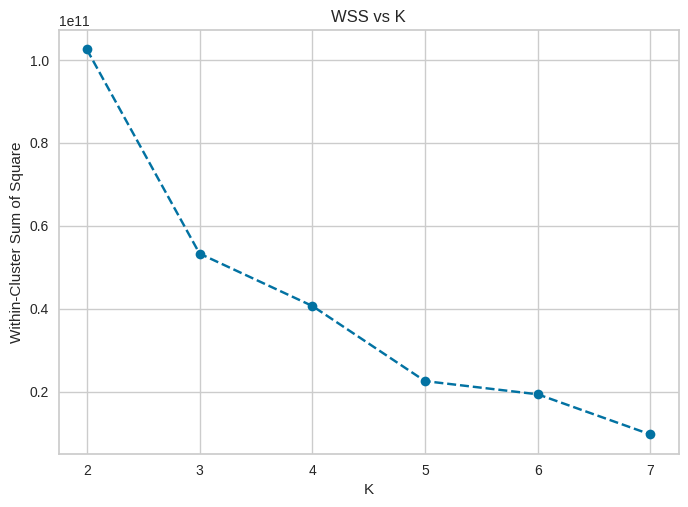

In [130]:
wss = []
for k in cluster:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # model training
    kmeans.fit(X)

    # validation
    wss.append(kmeans.inertia_)

# plot wss - Elbow Methods
plt.plot(cluster, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

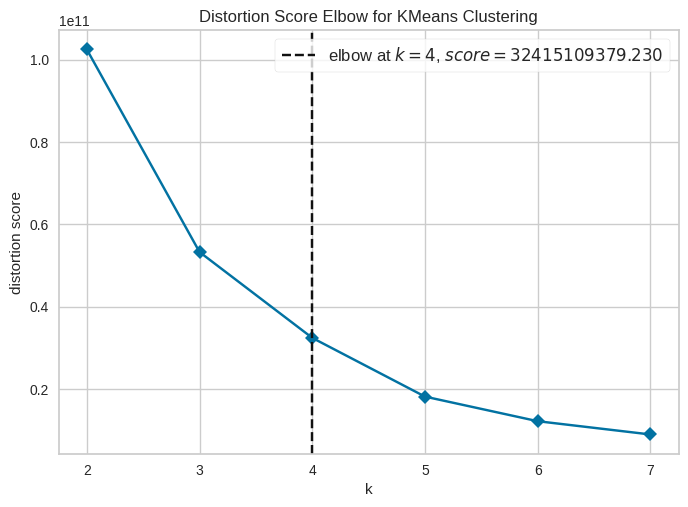

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [131]:
kmeans = KElbowVisualizer(KMeans(), k=cluster, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 SILLHOUETTE SCORE

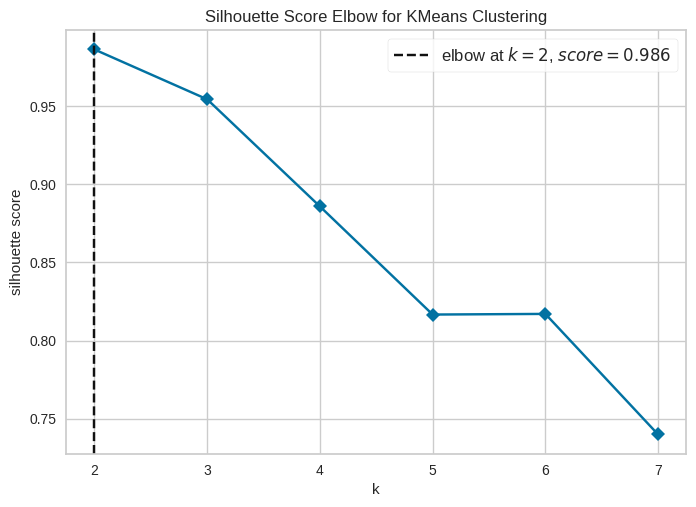

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [132]:
kmeans = KElbowVisualizer(KMeans(), k=cluster, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

### 7.2.1 SILHOUETTE ANALYSIS

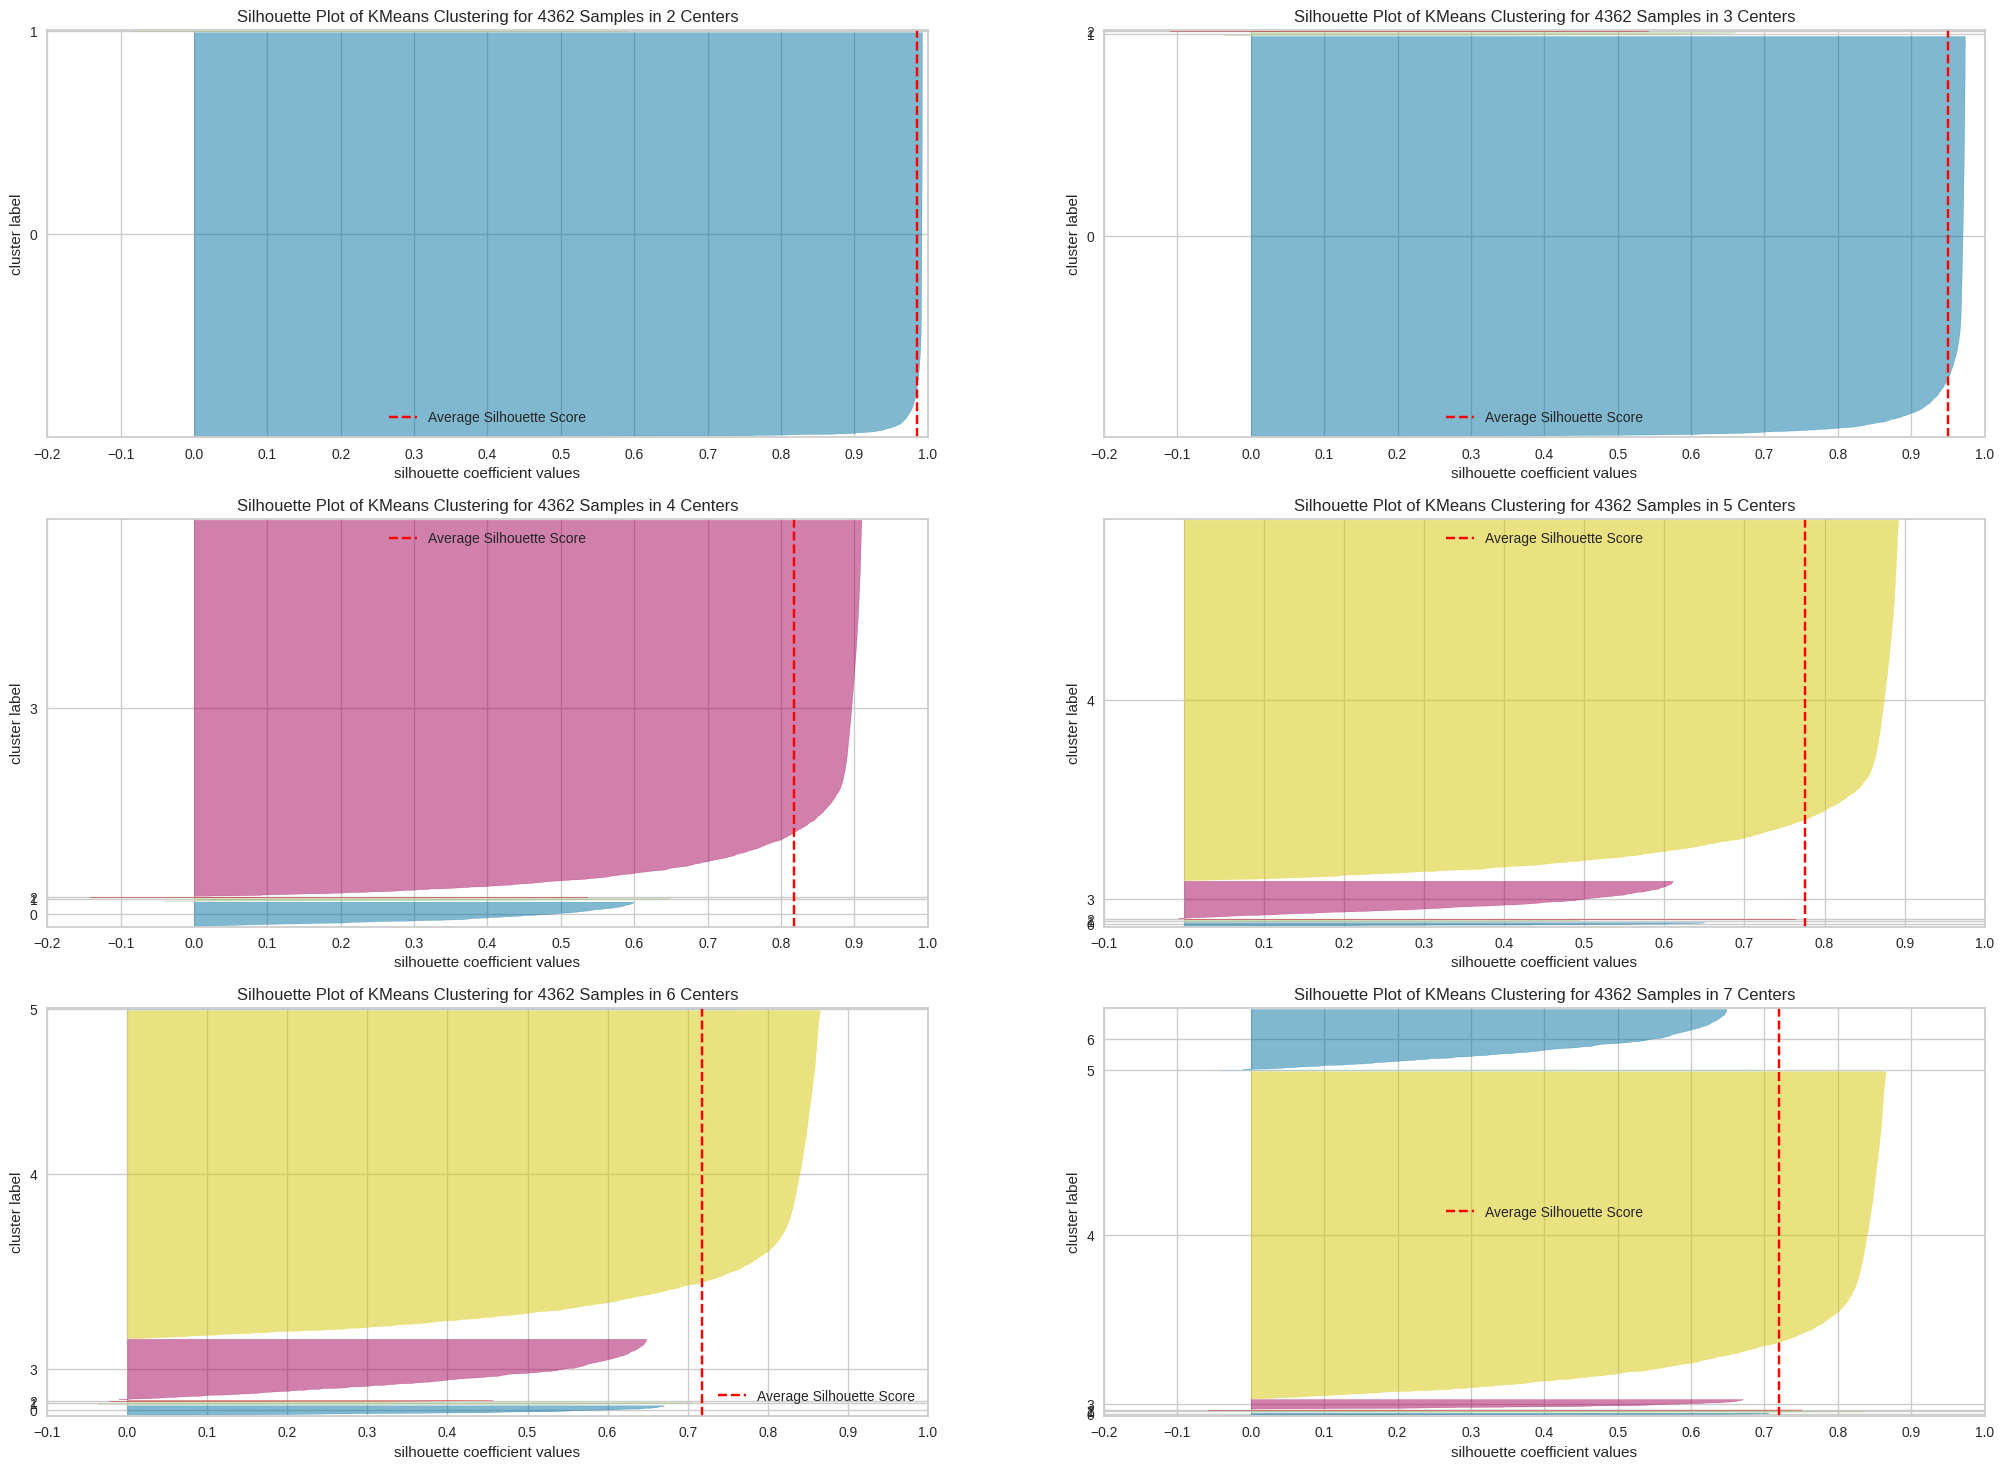

In [133]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in cluster:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax = ax[q -1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 MODEL TRAINING

## 8.1 K-Means

In [134]:
# model definition
k = 4
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 CLUSTER VALIDATION

In [135]:
# WSS - WITHIN-CLUSTER SUM OF SQUARE
print('WSS value: {}'.format(kmeans.inertia_))

## SS - SILHOUETTE SCORE
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 40653813588.337036
SS value: 0.8177087879526093


# 9.0 CLUSTER ANALYSIS

In [136]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,0
1,13047,3089.10,46,16,15.923196,3
2,12583,6629.34,2,17,28.209957,0
3,13748,948.25,95,5,33.866071,3
4,15100,635.10,330,6,105.850000,3


## 9.1 VISUALIZATION INSPECTION

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



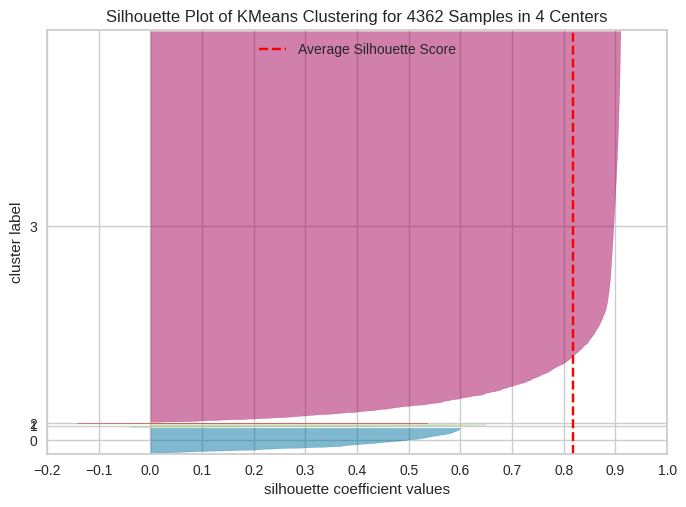

In [137]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 9.1.1 - 2d Plot

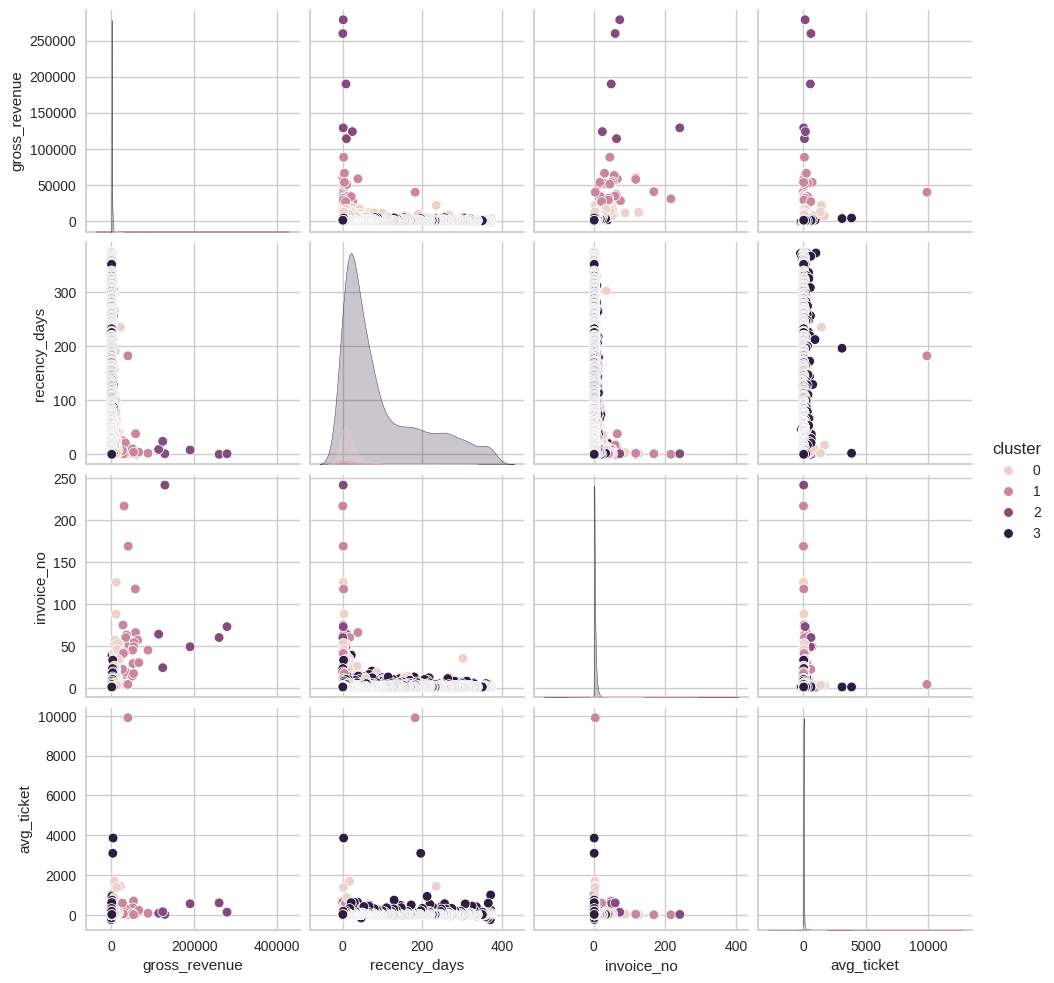

In [138]:
# 2d Plot
df9_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df9_viz, hue='cluster')

### 9.1.2 UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: xlabel='embedding_x', ylabel='embedding_y'>

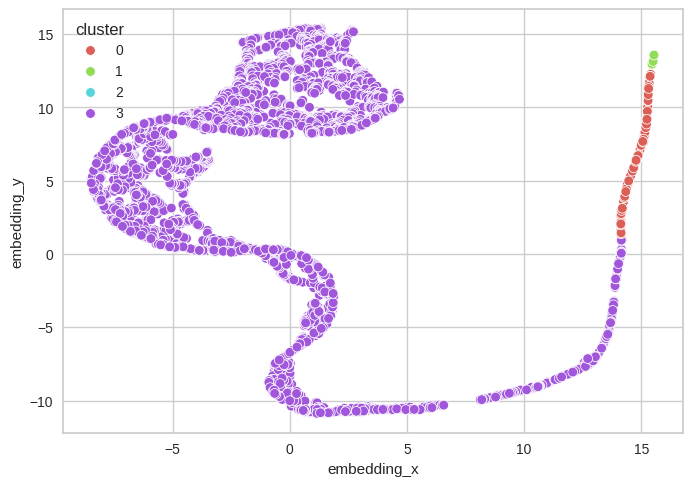

In [139]:
reducer = umap.UMAP( n_neighbors=20 ,random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df9_viz['embedding_x'] = embedding[:, 0]
df9_viz['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(
    x='embedding_x',
    y='embedding_y',
    hue='cluster',
    palette=sns.color_palette('hls', n_colors=df9_viz['cluster'].nunique()),
    data=df9_viz
)


In [92]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2 CLUSTER PROFILE

In [140]:
# number of customer
df9_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df9_cluster['perc_customer'] = 100 * (df9_cluster['customer_id'] / df9_cluster['customer_id'].sum())

# AVG Gros revenue
df9_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df9_avg_gross_revenue, on='cluster', how='inner')

# AVG - recency days
df9_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df9_avg_recency_days, on='cluster', how='inner')

# AVG - invoice_no
df9_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df9_avg_invoice_no, on='cluster', how='inner')

# AVG - Ticket
df9_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df9_ticket, on='cluster', how='inner')

df9_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,260,5.960569,8184.972192,20.384615,19.396154,65.205493
1,1,28,0.641907,43317.162143,12.571429,54.428571,502.830956
2,2,6,0.137552,182424.413333,7.166667,85.333333,259.765518
3,3,4068,93.259972,946.801704,96.873156,3.617502,27.192963


## Cluster 01: Probably Royalty
- Number of Customers: 6 ( 0.14% of Customers )
- AVG Recency: 7 days
- AVG Invoice: 89
- AVG Revenue: $ 182.182,00

## Cluster 02:
- Number of Customers: 31 ( 0.71% of Customers )
- AVG Recency: 14 days
- AVG Invoice: 53
- AVG Revenue: $ 40.543,52

## Cluster 03:
- Number of Customers: 4.335 ( 99% of Customers )
- AVG Recency: 92 days
- AVG Invoice: 5
- AVG Revenue: $ 1.372,57

# 10.0 DEPLOY TO PRODUCTION